In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

fetch the cats vs. dogs dataset using TFDS    
Transfer learning is most useful when working with very small datasets. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteATO8OJ/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


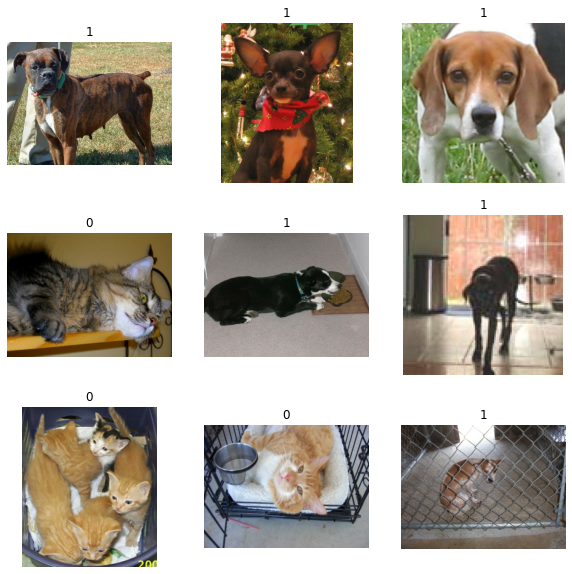

In [ ]:
# plotting first 9 images in the trainig dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

Images have variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for feeding a neural network. We need to do 2 things
* Standardize to a fixed image size. We pick 150x150.
* Normalize pixel values between -1 and 1. We'll do this using a Normalization layer as part of the model itself.

In [ ]:
size = (150,150)

train_ds = train_ds.map(lambda x,y : (tf.image.resize(x,size),y))
validation_ds = validation_ds.map(lambda x,y : (tf.image.resize(x, size),y))
test_ds = test_ds.map(lambda x,y : (tf.image.resize(x, size),y))

In [ ]:
# batching the data ans use caching and prefetching to optimize loading speed

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
# using random data augmentaion

from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip('horizontal'),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

Let's visualize what the first image of the first batch looks like after various random
 transformations:

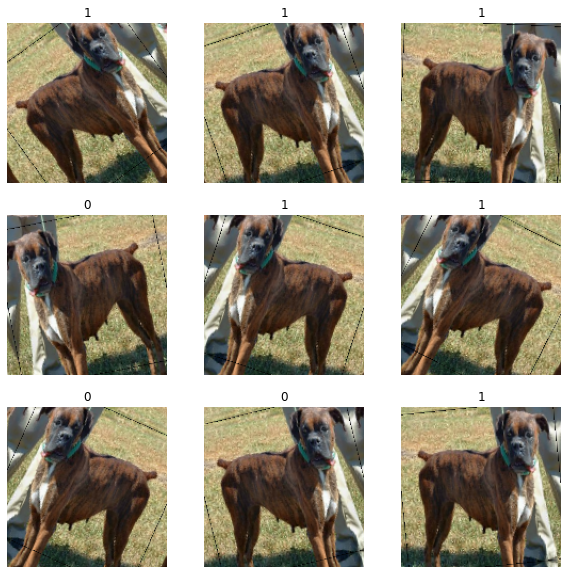

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(
        tf.expand_dims(first_image,0),training=True
    )
    plt.imshow(augmented_image[0].numpy().astype('int32'))
    plt.title(int(labels[i]))
    plt.axis('off')

Building a model

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet' , # load weights pretraioned on imagenet
    input_shape=(150,150,3),
    include_top = False # Do not imagent classifier on top
)

# Freeze the model
base_model.trainable = False

# Create a new model on the top
inputs = keras.Input(shape=(150,150,3))
x = data_augmentation(inputs)
# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5]*3)
var = mean ** 2
# Scale inputs to [-1,+1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs  = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [ ]:
# Train the top layer

model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()]
)

epochs = 20
model.fit(train_ds, epochs=epochs,validation_data=validation_ds )

Epoch 1/20
291/291 [==============================] - 1029s 4s/step - loss: 0.1663 - binary_accuracy: 0.9296 - val_loss: 0.0892 - val_binary_accuracy: 0.9678
Epoch 2/20
141/291 [=============>................] - ETA: 6:59 - loss: 0.1229 - binary_accuracy: 0.9486

Fine tuning of the entire model.    
Unfreeze the base model and train the entire model end-to-end with lower learning rate.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far

base_model.trainable = True
model.summary()

model.compile(
    optimizer = keras.optimizers.Adam(1e-5), # low learning rate
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()]
)

epochs = 10

model.fit(train_ds, epochs = epochs, validation_data=validation_ds)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                